# import libs

In [48]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#
import os
import sys
sys.path.append(confParser['input files']['lib_path'])
from dscribe.descriptors import SOAP
import ase
import ase.io
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.pyplot.rc('text', usetex=True)


#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)


conf. file sections: ['parameters', 'flags', 'MsdAnalysis', 'EnergyBarrier', 'SroAnalysis', 'input files', 'Atomic Radius']


<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

# set parameters

In [39]:
#--- set dynamic parameters
temp = confParser['parameters']['temperature']

#--- edit list of input files
confParser.set('input files','dump file',''.join([
               'allconf ', #0
              ]))
confParser.set('input files','diffusion file',''.join([
               'Diffusion.dat ', #0
              ]))


# Parse Lammps dump file

In [40]:
!rm -r dumpFile;mkdir dumpFile

#--- fetch parameters
path = confParser['input files']['input_path']
indx = confParser['input files']['fileIndex']
dumpFile = '%s/%s'%(path,confParser['input files']['dump file'].split()[int(indx)])
datFile = '%s/%s'%(path,confParser['input files']['diffusion file'].split()[int(indx)])
lib_path = confParser['input files']['lib_path']
outpt = 'dumpFile/dump.xyz'
outpt_headers = 'dumpFile/calcResults.txt'

#--- parse dump: call ovito
t0=time.time()
!ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers
print('output dump file=%s s'%(time.time()-t0))


#--- parse dump files
print('parsing %s'%(outpt))
t0=time.time()
lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
lmpData.GetCords( ncount = 1) #sys.maxsize)
print('elapsed time=%s s'%(time.time()-t0))

print('time steps:',lmpData.coord_atoms_broken.keys())
display(lmpData.coord_atoms_broken[0].head())

#--- add timescales
lmpData.times = np.loadtxt(datFile)[:,0]

#--- parse headers
lmpData.headers = pd.DataFrame(np.loadtxt(outpt_headers),columns=["Barrier", "Energy", "Step", "Time"])

output dump file=3.3286445140838623 s
parsing dumpFile/dump.xyz
elapsed time=0.014086246490478516 s
time steps: dict_keys([0, 1])


,id,type,x,y,z
0,1,2,3.867879,18.055094,7.422952
1,2,1,9.194937,2.046315,3.873742
2,3,3,9.203422,21.626698,2.083052
3,4,3,2.095637,5.627621,7.422738
4,5,1,18.064135,12.749897,2.083203


# Energy

In [41]:
class EnergyBarrier:
    '''
    return energy barriers corresponding to diffusional hopping
    '''
    def __init__(self,
                 events_directory,evlist_directory,
                 lmpData,
                 nmax = sys.maxsize,
                 verbose=False):
        self.events_dir = events_directory
        self.evlist_dir = evlist_directory
        self.lmpData = lmpData.coord_atoms_broken[0]
        #--- soap parameters
        self.species = 'Co Ni Cr Fe Mn'.split()
        self.r_cut = 6.0
        self.n_max = 8
        self.l_max = 6
        #
        self.nmax = np.min(np.array([nmax,sys.maxsize]))
        self.verbose = verbose
        
    def Parse(self):
        '''
        parse event files
        '''
        self.events_id_energy = self.ParseEvents_dir()
        self.catalog          = self.ParseEvList_dir()
        self.diffusionPaths   = self.ParseDiffusionPath()
        
        
    def ParseEvents_dir(self):
        '''
        return energy barriers associated with hopping events
        '''
        files = os.listdir(self.events_dir)
        d=[]
        count = 0
        for sfile in files:
            if not '.xyz' in sfile: #--- skip .xyz files 
                try:
                    filee=open('%s/%s'%(self.events_dir,sfile)) #--- open file
                    xstrs = filee.readlines()
                    event_id = int(xstrs[0].split()[-1]) #--- event id
                    barrier = float(xstrs[2].split()[-1]) #--- energy
                    ncluster =  int(xstrs[15].split()[-1])                 
                    shape_cluster_atoms =  int(xstrs[16].split()[-1])
                    atom_id = int(xstrs[17+ncluster].split()[0])
                    if self.verbose:
                        print('file=%s atom_id=%s'%(sfile,atom_id))
                    d = np.c_[event_id,atom_id,barrier] if len(d) == 0 else\
                    np.concatenate([d,np.c_[event_id,atom_id,barrier]])
                    #
                    if count > self.nmax:
                        break
                    count += 1
                except:
#                    traceback.print_exc()
                    continue
            
        #--- extract types
        df       = self.lmpData
        atom_ids = d[:,1]
        types    = utl.FilterDataFrame(df, 
                    key='id', 
                    val=atom_ids
                   )['type']

        return pd.DataFrame(np.c_[types,d],columns=['atom_type','event_id','atom_id','barrier'])

    @staticmethod
    def ReadConfigurationFile(dumpFile, outpt, outpt_headers):
        '''
        return displacements
        '''
#        !rm outpt outpt_headers
        lib_path = confParser['input files']['lib_path']

        #--- parse dump: call ovito
        !ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers

        #--- parse dump files
        lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
        lmpData.GetCords( ncount = sys.maxsize)

        #--- disp
        fileCurr = fileRef = outpt #'dumpFile/dump.xyz'
        outpt = 'disp.xyz'
#        !rm $outpt

        #--- call ovito
        os.system('ovitos %s/OvitosCna.py %s %s 1 8 %s'%(lib_path,fileCurr,outpt,fileRef))

        #--- parse disp files
        lmpDisp = lp.ReadDumpFile( outpt )
        lmpDisp.GetCords( ncount = sys.maxsize )
        return lmpDisp

    @staticmethod
    def GetEventid(filestr):
        '''
        extract event id from input string
        '''
        n = len(filestr)
        return int(filestr[5:n-4])
    
    def ParseDiffusionPath(self):
        '''
        return diffusion path corresponding to hopping events
        '''
        disps = {}
        count = 0
        files = os.listdir(self.events_dir)
        self.events_id_energy
        for event_id in list(map(int,self.events_id_energy.event_id)):
#        for sfile in files:
#            if '.xyz' in sfile: #--- skip .xyz files 
#                try:
                    dumpFile = '%s/event%s.xyz'%(self.events_dir,event_id) #--- open file
                    #         outpt = 'dumpFile/dump.xyz'
#                    event_id = EnergyBarrier.GetEventid(sfile)
                    disps[event_id] = \
                    EnergyBarrier.ReadConfigurationFile(dumpFile, 'dump.xyz', 'calcResults.txt')
                    if self.verbose:
                        print('file=%s atom_id=%s'%(sfile,atom_id))
                    #
                    if count > self.nmax:
                        break
                    count += 1
#                 except:
#                     traceback.print_exc()
#                     continue
        return disps
    
    def ParseEvList_dir(self):
        files = os.listdir(self.evlist_dir)
        events={}
        for sfile in files:
            try:
                kmc_step = int(sfile.split('_')[-1])
        #        print(kmc_step)
                filee=open('%s/%s'%(self.evlist_dir,sfile)) #--- open file
                events[kmc_step] = pd.read_csv(filee,delim_whitespace=True).iloc[1:]#delimiter='')
            except:
                continue
        return events
        
    def SplitByType(self):
        '''
        return energies (parsed from catalogs) slipt by atom types
        '''
        kmc_steps = list(self.catalog.keys())
        kmc_steps.sort()


        #--- dict based on types
        df_concat = {}
        types = list(set(self.lmpData.type))
        for itype in types:
            df_concat[str(itype)] = {}

        for kmc_step in kmc_steps: #--- kmc loop
            df = self.catalog[kmc_step]
            sdict=df.groupby(by='#TypeId').groups #--- group by type
            for itype in sdict:
                indices = sdict[itype] #--- row index: atoms with  '#TypeId' == itype
                cond = len(df_concat[itype]) == 0 #--- empty key?
                df_concat[itype] = np.c_[df.loc[indices]] if cond else\
                np.concatenate([df_concat[itype],np.c_[df.loc[indices]]],axis=0)

        self.energyByType = {}
        for itype in df_concat:
             self.energyByType[ itype ] = pd.DataFrame(df_concat[itype],columns=list(df.keys()))        

    def SetDescriptors(self, event_id):
        
        positions = self.diffusionPaths[event_id].coord_atoms_broken[0]['x y z'.split()]

        #--- convert to lammps data file
        atom = lp.Atoms(**self.diffusionPaths[event_id].coord_atoms_broken[0].to_dict(orient='series'))
        box = lp.Box(BoxBounds=lmpData.BoxBounds[0],AddMissing=np.array([0,0,0]))
        wd = lp.WriteDataFile(atom, box, {1:1,2:1,3:1})
        wd.Write('lammps.dat')

        
        
        
        atoms = ase.io.read("lammps.dat",format="lammps-data",style='atomic')


        # Setting up the SOAP descriptor
        soap = SOAP(
            species=self.species,
            periodic=False,
            r_cut=self.r_cut,
            n_max=self.n_max,
            l_max=self.l_max,
        )


        # set atomic numbers for each species
        numbers = list(map(lambda x:soap.index_to_atomic_number[x-1],atoms.get_atomic_numbers()))
        atoms.set_atomic_numbers(numbers)
        #assert soap.check_atomic_numbers(atoms.get_atomic_numbers())

        #--- center atom is the last entry
        soap_descriptors = soap.create( atoms,centers=[atoms.get_number_of_atoms()-1])
        

        return soap_descriptors[0]
    
    
    def SetDescriptorsMultipleEvents(self):
        events = list(self.diffusionPaths.keys())
        self.descriptors = np.c_[list(map(lambda x:self.SetDescriptors(x), events))]


In [42]:
# %pfile lp.WriteDataFile

## main()

In [43]:
def main():
    if not eval(confParser['EnergyBarrier']['EnergyBarrier']):
        return
    
    eb = EnergyBarrier('%s/EVENTS_DIR'%confParser['input files']['input_path'],
                       '%s/EVLIST_DIR'%confParser['input files']['input_path'],
                       lmpData,
                       nmax = 100,
#                       verbose = True,

                      )
    eb.Parse()
    #eb.events_id_energy extract from Events_dir
    #eb.energyByType extract from catalogs
    
#     pdb.set_trace()
#     event_id =list(eb.diffusionPaths.keys())[0]
#     udisp = eb.diffusionPaths[event_id].coord_atoms_broken[2]['DisplacementX DisplacementY DisplacementZ'.split()]
#     positions = eb.diffusionPaths[event_id].coord_atoms_broken[0]['x y z'.split()]
#     filtr = eb.events_id_energy.event_id == event_id
#     energies = eb.events_id_energy[filtr].barrier.iloc[0]

    #--- setup descriptors
    eb.SetDescriptorsMultipleEvents()


    #--- train nn
    

    #--- write to file
    with open('eventID_barrier.txt','w') as fp:
        np.savetxt(fp,
                   np.c_[eb.events_id_energy],
                   header='atom_type event_id atom_id barrier')


    return eb
data = main()

# Train NN

Help on class MLPRegressor in module sklearn.neural_network._multilayer_perceptron:

class MLPRegressor(sklearn.base.RegressorMixin, BaseMultilayerPerceptron)
 |  MLPRegressor(hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
 |  
 |  Multi-layer Perceptron regressor.
 |  
 |  This model optimizes the squared error using LBFGS or stochastic gradient
 |  descent.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : tuple, length = n_layers - 2, default=(100,)
 |      The ith element represents the number of neurons in the ith
 |      hidden layer.
 |  
 |  activation : {'identity', 'logis

In [46]:
data.events_id_energy

,atom_type,event_id,atom_id,barrier
0,1.0,885097.0,327.0,1.111131
1,3.0,1262565.0,1258.0,0.545125
2,2.0,624472.0,218.0,0.392549
3,1.0,1679.0,656.0,0.667566
4,1.0,568326.0,1268.0,0.495080
...,...,...,...,...
97,3.0,150399.0,746.0,0.411171
98,1.0,484172.0,1041.0,0.936159
99,3.0,63480.0,475.0,0.575047
100,2.0,502610.0,417.0,0.574036


In [68]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = data.descriptors, np.c_[data.events_id_energy['barrier']] #make_regression(n_samples=200, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,)# random_state=1)
regr = MLPRegressor(max_iter=500).fit(X_train, y_train)
y_pred_test = regr.predict(X_test)
y_pred_train = regr.predict(X_train)




<AxesSubplot:xlabel='$E_\\mathrm{act}$', ylabel='$E_\\mathrm{pred}$'>

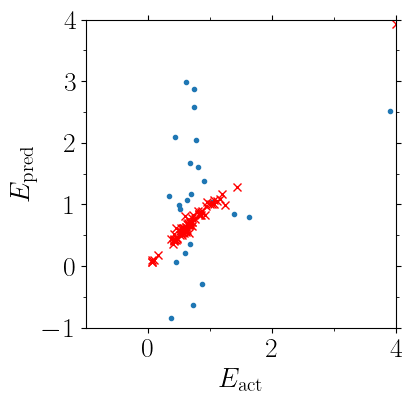

In [71]:
ax = utl.PltErr(None,None,Plot=False)

utl.PltErr(y_test,y_pred_test,
           attrs={'fmt':'.','color':'C0'},
           ax=ax,
           Plot=False,
          )

utl.PltErr(y_train,y_pred_train,
           attrs={'fmt':'x','color':'red'},
           ax=ax,
           Plot=False
          )

utl.PltErr(None,None,
          xlim=(-1,4),
          ylim=(-1,4),
           xstr=r'$E_\mathrm{act}$',
           ystr=r'$E_\mathrm{pred}$',
           ax=ax,
           Plot=False
          )
